In [2]:
import tensorflow as tf
import PIL
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib


In [4]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir=keras.utils.get_file('flower_photos.tar',origin=dataset_url,extract=True)
data_dir=pathlib.Path(data_dir).with_suffix("")

228813984/228813984 [==============================] - 18s 0us/step


3670


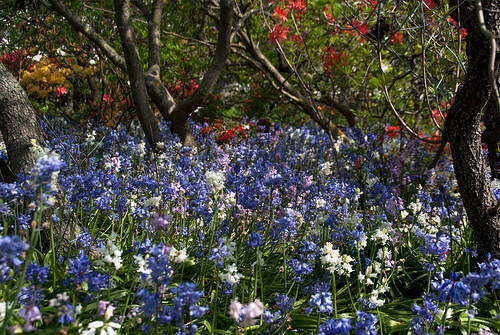

In [7]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))
PIL.Image.open(str(roses[1]))
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))
PIL.Image.open(str(tulips[1]))

In [29]:
batch_size = 64
img_height = 180
img_width = 180


In [30]:
train_ds=keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset='training',
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size
)

val_ds=keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset='validation',
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size
)
class_names=train_ds.class_names
print(class_names)

Found 3670 files belonging to 5 classes.
Using 2569 files for training.
Found 3670 files belonging to 5 classes.
Using 1101 files for validation.
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


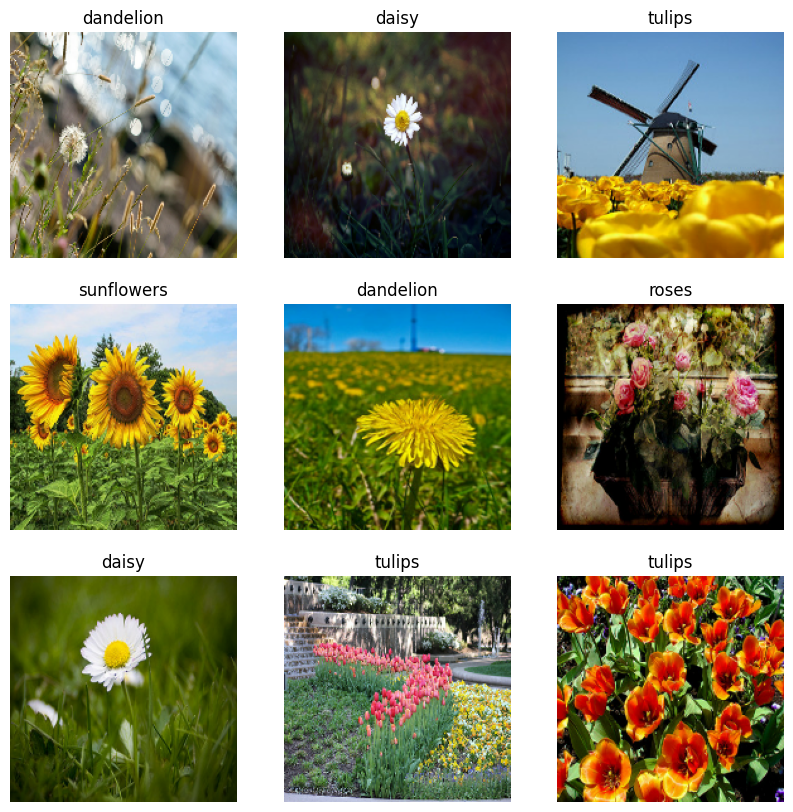

In [31]:
plt.figure(figsize=(10,10))
for img,lab in train_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(img[i].numpy().astype('uint8'))
        plt.title(class_names[lab[i]])
        plt.axis('off')


In [32]:
for image_batch,label_batch in train_ds:
    print(image_batch.shape)
    print(label_batch.shape)
    break

(64, 180, 180, 3)
(64,)


In [33]:
AUTOTUNE=tf.data.AUTOTUNE
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds=val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [34]:
num_classes=len(class_names)
model=Sequential([
    layers.Rescaling(1./255,input_shape=(img_height,img_width,3)),
    layers.Conv2D(16,3,padding='same',activation=layers.LeakyReLU(alpha=0.1)),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3,padding='same',activation=layers.LeakyReLU(alpha=0.1)),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3,padding='same',activation=layers.LeakyReLU(alpha=0.1)),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='tanh'),
    layers.Dense(num_classes)
])
model.compile(
    optimizer='adam',
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

In [35]:
epochs=10
history=model.fit(train_ds,validation_data=val_ds,epochs=epochs)

Epoch 1/10
41/41 [==============================] - 7s 113ms/step - loss: 1.6009 - accuracy: 0.4243 - val_loss: 1.1105 - val_accuracy: 0.5486
Epoch 2/10
41/41 [==============================] - 3s 65ms/step - loss: 1.0332 - accuracy: 0.5948 - val_loss: 1.0447 - val_accuracy: 0.5740
Epoch 3/10
41/41 [==============================] - 3s 64ms/step - loss: 0.9041 - accuracy: 0.6489 - val_loss: 1.0088 - val_accuracy: 0.6131
Epoch 4/10
41/41 [==============================] - 3s 64ms/step - loss: 0.7821 - accuracy: 0.6937 - val_loss: 0.9879 - val_accuracy: 0.6231
Epoch 5/10
41/41 [==============================] - 3s 64ms/step - loss: 0.6619 - accuracy: 0.7591 - val_loss: 0.9819 - val_accuracy: 0.6176
Epoch 6/10
41/41 [==============================] - 3s 64ms/step - loss: 0.4969 - accuracy: 0.8237 - val_loss: 0.8747 - val_accuracy: 0.6839
Epoch 7/10
41/41 [==============================] - 3s 64ms/step - loss: 0.3166 - accuracy: 0.8988 - val_loss: 0.9676 - val_accuracy: 0.6676
Epoch 8/10
4

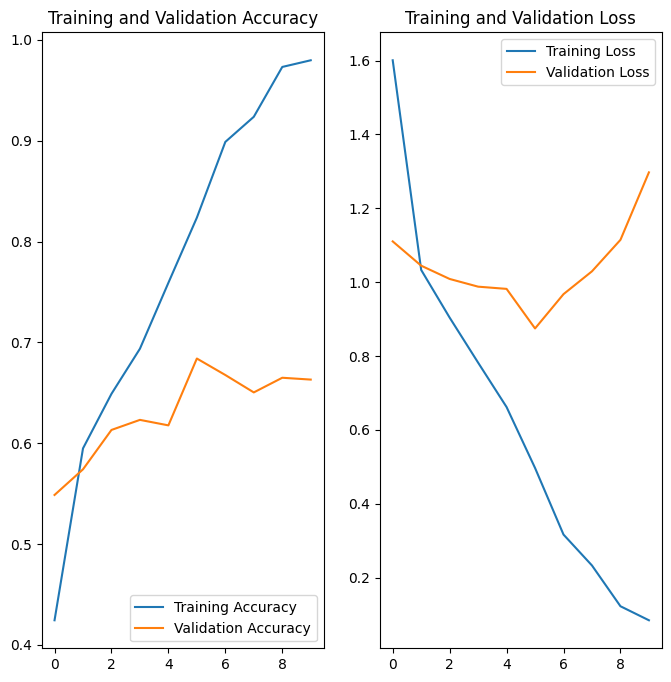

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

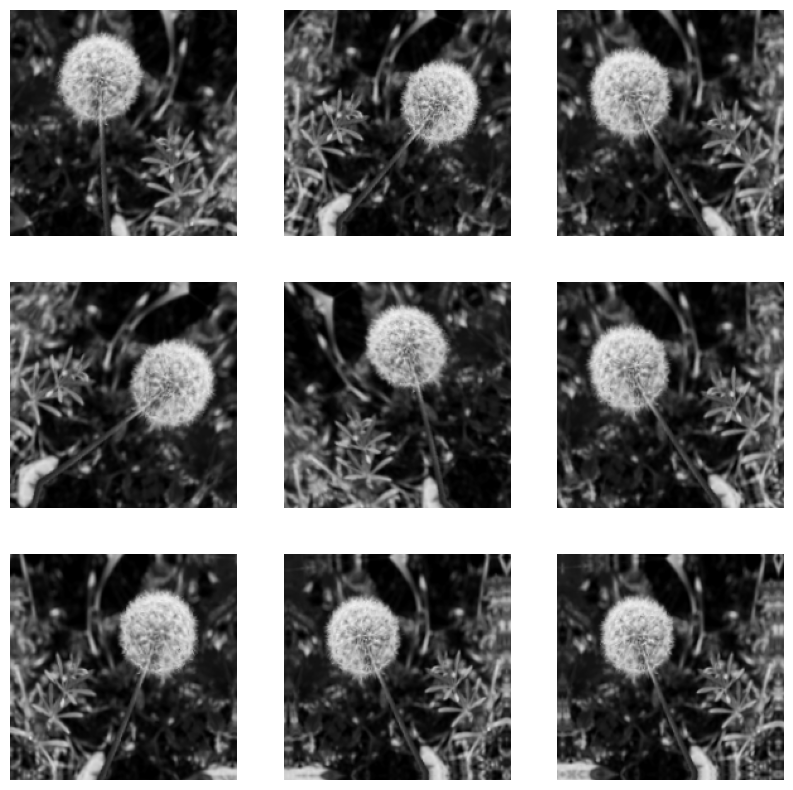

In [40]:
data_augmentation=keras.Sequential([
    layers.RandomFlip('horizontal',input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])
plt.figure(figsize=(10,10))
for images,_ in train_ds.take(1):
    for i in range(9):
        augmented_images=data_augmentation(images)
        ax=plt.subplot(3,3,i+1)
        plt.imshow(augmented_images[0].numpy().astype('uint8'))
        plt.axis("off")

plt.show()

In [43]:
model=Sequential([
    data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [44]:
epochs=15
history=model.fit(
    train_ds,validation_data=val_ds,epochs=epochs
)

Epoch 1/15
41/41 [==============================] - 36s 785ms/step - loss: 1.3652 - accuracy: 0.4002 - val_loss: 1.1491 - val_accuracy: 0.5568
Epoch 2/15
41/41 [==============================] - 33s 801ms/step - loss: 1.0716 - accuracy: 0.5648 - val_loss: 1.1267 - val_accuracy: 0.5486
Epoch 3/15
41/41 [==============================] - 33s 812ms/step - loss: 0.9609 - accuracy: 0.6248 - val_loss: 1.0152 - val_accuracy: 0.6022
Epoch 4/15
41/41 [==============================] - 36s 883ms/step - loss: 0.9003 - accuracy: 0.6512 - val_loss: 0.9850 - val_accuracy: 0.6231
Epoch 5/15
41/41 [==============================] - 38s 923ms/step - loss: 0.8485 - accuracy: 0.6804 - val_loss: 0.9852 - val_accuracy: 0.6158
Epoch 6/15
41/41 [==============================] - 38s 941ms/step - loss: 0.8126 - accuracy: 0.6808 - val_loss: 0.9886 - val_accuracy: 0.6385
Epoch 7/15
41/41 [==============================] - 38s 939ms/step - loss: 0.7384 - accuracy: 0.7151 - val_loss: 0.8797 - val_accuracy: 0.6658

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)